# Map Analysis
### Jeff McMahon and Renée Hložek 

We will analyze these maps in several ways. First, in this part, we will use a Monte Carlo technique to recover the power spectrum, with exercises along the way. In part five we will, use a matched filter to isolate the SZ signal and point sources, and work through stacking a map on a cluster catalogue from a simulated external survey (e.g., optical or x-ray).

## Power spectrum
 
In this section we compute the power spectrum of a CMB map.  We will work in the flat sky approximation which is described above in the section where we generated the simulated CMB map.  

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

## Recalculating the results from the previous stages

Number of sources required:  5000
map mean: -39.728687525471464 map rms: 108.57043780821975


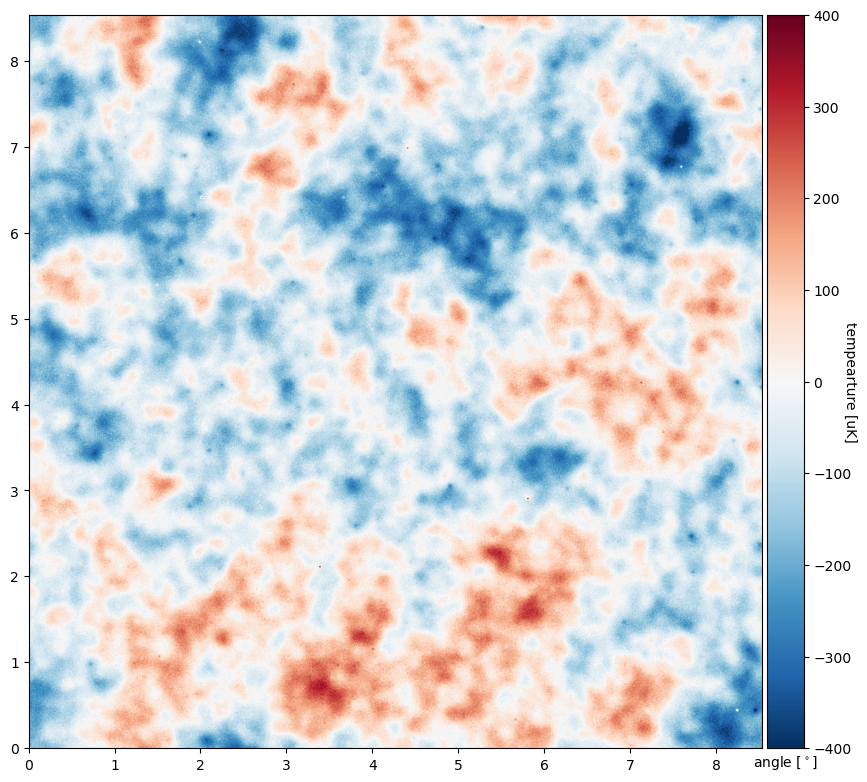

In [2]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

### Apodize  the map to eliminate edge effects

Before taking a 2d FFT (eg the obvious thing to do for computing a power spectrum) we must apodize the maps to eliminate edges effects.  Edge effects come about because the Fourier transform treats a square array as having periodic boundaries.  Thus if we take the Fourier transform of a 2-dimensional map and the values on the left and right side (and also, top and bottom) of the map don't match, we end up generating spurious signals.   In this example we use a cosine window to smoothly roll off the signal to zero as we approach the edges of the map.  There are many choices of windows that trade sensitivity loss, coupling of adjacent modes, and ringing.

map mean: -17.50367665087078 map rms: 53.43385892423731


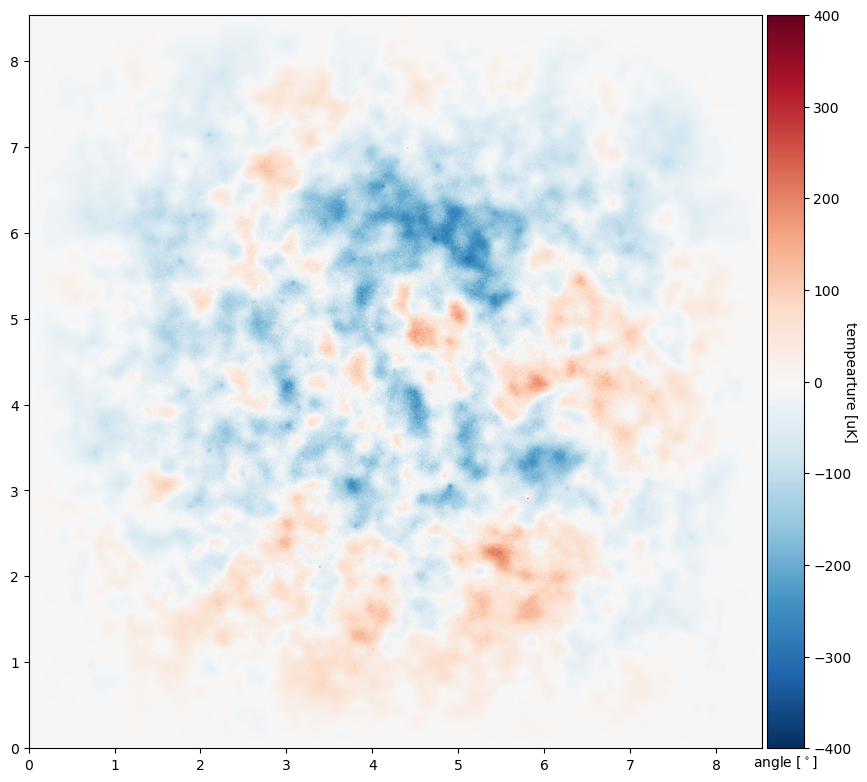

In [3]:
def cosine_window(N):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    N=int(N) 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.)/N *np.pi ## eg runs from -pi/2 to pi/2
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)
  ###############################
    
window = (cosine_window(N))
    
appodized_map = window * total_map_plus_noise

p=Plot_CMB_Map(appodized_map,c_min,c_max,X_width,Y_width)

This shows our simulated map with a cosine window applied to eliminate edge effects.  It is obvious from this map that we are suppressing the signal here.
<font color='red'>EXCERCISE: </font>  There are an huge number of well studied windows with various combinations of properties.   Some minimize mode coupling, others minimize signal loss, while others maximize some combination of the two.  Find the wikipedia article on Fourier transform windows, choose one of your favorites and implement it as an option.  Compare the impact of the new window compared to the simple cosine window on the map.

In [16]:
## your code and plots go here

Your comments go here.

### Naive Powerspectrum

Here we compute a naive power spectrum and compare it to the input power spectrum for our simulations.  The power spectrum is computed by: (1) applying a 2d FFT, (2) taking the absolute value squared of this map in Fourier space ($k_x$ and $k_y$), and (3) averaging the signal in annular bins of $k = \sqrt{k_x^2 + k_y^2}$.  These bins are converted to bins in $\ell$ with the scaling: $\ell = k* 2 \pi$ per the flat sky approximation.   NOTE: step 3 (averaging in radial bins) is how we convert our 2d Fourier map into a 1d power spectrum.

Our spectrum code takes two maps as inputs to allow for cross spectra when we get to polarizaiton in Part Seven.

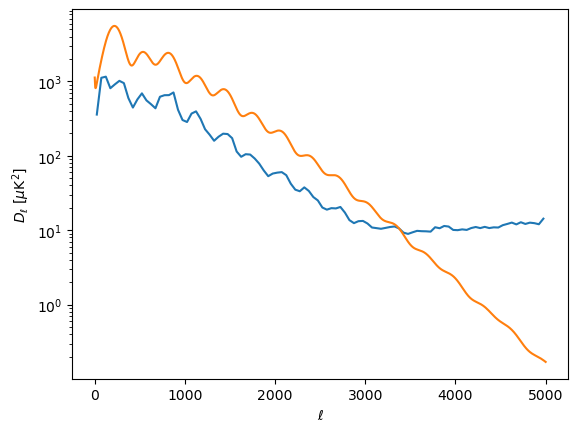

In [4]:
#### parameters for setting up the spectrum
delta_ell = 50.
ell_max = 5000.

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

This plot shows the input CMB power spectrum (green) and the naive power spectrum we estimated from our CMB map (blue).  The naive spectrum does not match the input due to a combination of: instrumental noise, SZ and point source signals; and suppression from the beam and the apodization.   

<font color='red'>EXCERCISE: </font>  Comment on how the measured power sepctrum (blue) compares to the input spectrum (green).  Why are they different?  What features are common to both?  How does your alternative window funciton affect the measured spectrum compared to the default?

In [18]:
## your code and plots go here

Your comments go here.

### Correcting the biases in the naive power spectrum

To correct the naive spectrum and obtain an unbiased estimate of the underlying power spectrum in our simulated map we must correct additive bias and multiplicative bias.   We can relate our measured spectrum $\hat D_\ell$ to the true underlying spectrum $D_\ell$ as follows:

$$\hat D_\ell = T*D_\ell + N. $$

Here $N$ represents an additive noise term and $T$ represents a transfer function of the instrument (beam) and filtering (in this case the apodization, but other processing can enter, for example a 1-d high pass filter to eliminate striping).   All of these terms are functions of $\ell$.

The true power spectrum can be recovered by using monte carlo technqies.  To apply this technique we use simulations to calibrate $T$ and $N$ and then use algebra to correct the naive measurement.  This is compactly expressed in the following equation:

$$ D_\ell = \hat (D_\ell - N)/T. $$

In the next two sections we use simulations to calibrate $T and $N$ to recover an unbiased estimate of the underlying power spectrum.  Subsequently we will used monte carlo simulations to estimate the error bars on this measurement.

### Calibrating the transfer function

The transfer function can be calibrated by: (1) generating sky simulations with a known power spectrum, modeling the transfer function of the instrument and the post-processing, and keeping the noise level to zero,; and (2) calculating the naive power spectrum from each simulation, (3) running many simulations to reduce numerical noise, and (4) dividing the true spectrum by the the average signal only spectrum to recover our estimate for the transfer function.   The accuracy depends on the number of realizations used.  Here  we used 64 realizations as a compromise between speed and accuracy.  

Here we use a CMB only spectrum to estimate the transfer function.  We could improve the estimate of the transfer function by using an input power spectrum that is modified to follow the effect of point sources.  This could be added as an exercise.  In this exercise compare the transfer function to find out how much the choice of input spectrum matters.

 signal only sims, iterations complete: 16 of 16

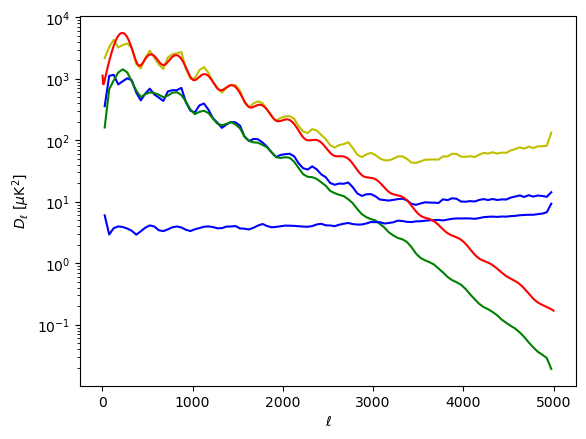

In [5]:
N_iterations = 16

signal_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(CMB_T_convolved*window,CMB_T_convolved*window,delta_ell,ell_max,pix_size,N)
    signal_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra = np.zeros(N_ells)
    rmsSpectra = np.zeros(N_ells)
    
    # calcuate the average spectrum
    i = 0
    while (i < N_spectra):
        avgSpectra = avgSpectra + spectra[i,:]
        i = i + 1
    avgSpectra = avgSpectra/(1. * N_spectra)
    
    #calculate the rms of the spectrum
    i =0
    while (i < N_spectra):
        rmsSpectra = rmsSpectra +  (spectra[i,:] - avgSpectra)**2
        i = i + 1
    rmsSpectra = np.sqrt(rmsSpectra/(1. * N_spectra))
    
    return(avgSpectra,rmsSpectra)


sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,int(ell_max/delta_ell))
    
sub_sampled_CLs = DlTT[binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Multiplicative_Bias_est =  sub_sampled_CLs / sig_only_mean_spectrum
   
## make some plots
plt.clf()
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

This plot shows the estimate of the CMB power spectrum after correcting for the multiplicative bias (transfer function) in yellow.   In addition we show (red) the input CMB power spectrum, (green) the average of the signal only simulations, (blue, lower) the transfer function, and (blue, upper) the naive power spectrum of our map.  Consider how all these curves relate to creating the yellow estimate.
<font color='red'>EXCERCISE: </font>  Why does the green curve look so much like the red curved but surpressed?  What is the meaning of the lower (and smoother) blue curve?

Your comments go here.

### Calibrating the noise bias

The noise bias can be computed by running noise only simulations through the naive power spectrum estimator and computing the average power spectrum.

NOTE: An alternative approach exists for dealing with the noise.  If you can subdivide your data into subsets with common signal but independent noise, one can compute "cross-spectra" between these subsets.  (You compute these by doing a 2d FFT on each subset and then multiplying one by the complex conjugate of the other.)   This results in some information loss (since you are throwing out the auto-correlation of each subset, but it completely eliminates potential measurement bias from an incorrect noise model.  

As a two part exercise: (1) use the wrong noise model in analyzing the power spectrum to see what happens, and (2) implement a cross-spectrum estimator to see that this noise bias goes away with cross spectra.  Also note that the error bars grow with the cross spectrum. 

 noise only sims, iterations complete: 16 of 16

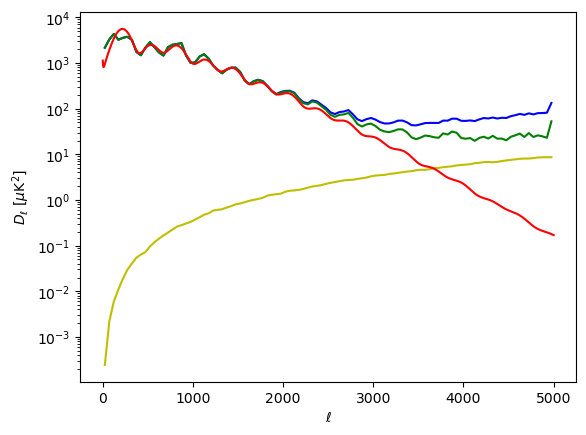

In [6]:
noise_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Noise*window,Noise*window,delta_ell,ell_max,pix_size,N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum, rms_not_needed = average_N_spectra(noise_only,N_iterations,int(ell_max/delta_ell))

Additive_Bias_est = noise_only_mean_spectrum


#plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
#plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(binned_ell,(noise_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')
#plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est*\
             binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
plt.semilogy(binned_ell,(binned_spectrum -noise_only_mean_spectrum)\
             *Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

The green curve in this plot shows our unbiased estimate for the spectrum.  This estimate includes corrections for the noise bias and the transfer function.  The yellow curve shows our estimate for the noise only additive bias.  The blue curve shows the spectrum accounting for only the multiplicative bias as was done above.  The red curve shows the underlying power spectrum used in generating our simulated map.

At this point we have an unbiased estimate of the power spectrum (the green curve). Note that at high-$\ell$  the spectrum is dominated by the SZ and point source components.  Next we need to put error bars on this measurement.  Again we do this with the monty carlo approach.

<font color='red'>EXCERCISE: </font>  What is the yellow curve?  How is it generated, how is it used to get the green curve?

your comments go here

### Quantifying the error bars

The error bars are computed by generating simulations including signal and noise, computing the naive power spectrum, taking the RMS of these results and then subtracting the noise bias and accounting for the transfer function.  In effect we are simulating running the experiment a bunch of times and looking at the RMS of the results--- this approach is broadly applicable to other problems.

Number of sources required:  5000
 signal and noise sims, iterations complete: 1 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 2 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 3 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 4 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 5 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 6 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 7 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 8 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 9 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 10 of 16Number of sources required:  5000
 signal and noise sims, iterations complete: 11 of 16Number of sources required:  5000
 signal and noise 

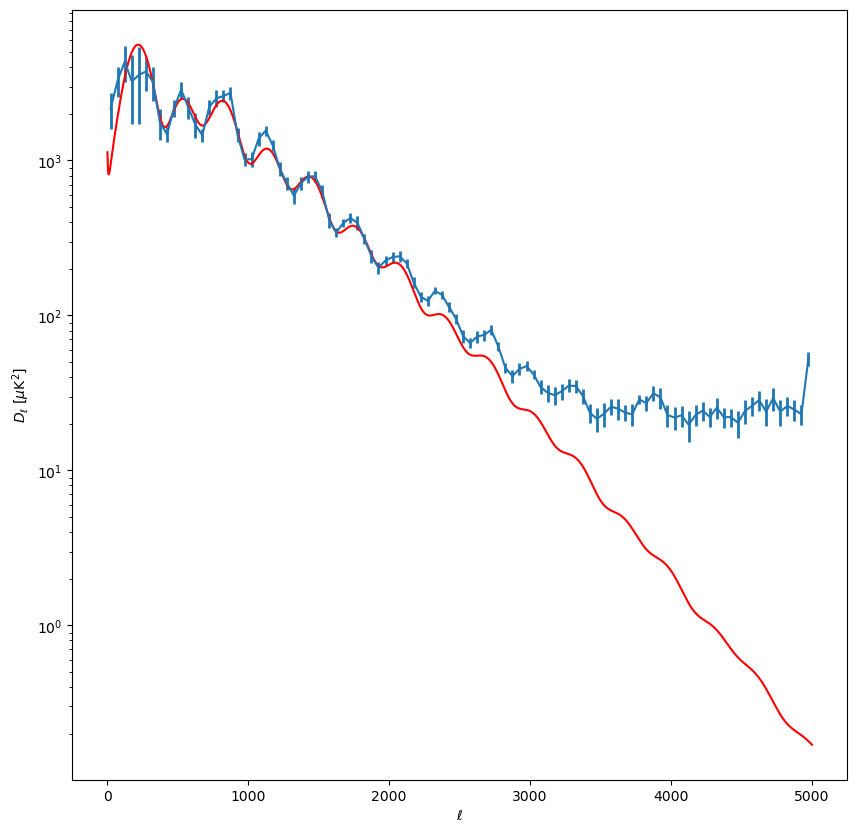

In [7]:
SplusN  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

    PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                      Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    
    CMB_T  = CMB_T + PSMap + SZMap

    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum((CMB_T_convolved+Noise)*window\
                                                                ,(CMB_T_convolved+Noise)*window\
                                                                ,delta_ell,ell_max,pix_size,N)
    SplusN[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal and noise sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    #p=Plot_CMB_Map(CMB_T_convolved+Noise,c_min,c_max,X_width,Y_width)
    i = i + 1
    
mean_not_needed,rms_sig_plus_noise = average_N_spectra(SplusN,N_iterations,int(ell_max/delta_ell))


plt.clf()
plt.gcf().set_size_inches(10, 10)
plt.errorbar(binned_ell, (binned_spectrum -noise_only_mean_spectrum)*Multiplicative_Bias_est* \
             binned_ell * (binned_ell+1.)/2. / np.pi, \
             yerr=rms_sig_plus_noise*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,\
             elinewidth=2)
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()




And there you have it.  That is how you compute a CMB power spectrum and error bars.   If you want to fit cosmology to these data you can re-run CAMB varying cosmological parameters and compute the likelihood difference between these models and the data.  This is left as an exercise.
<font color='red'>EXCERCISE: </font>  Why dosn't the red curve (input CMB spectrum) fall wihin the error bars of our simulated data set above $\ell \sim 2500$?

your comments and discussion go here

<font color='red'>EXCERCISE: </font>  One can worry that the transfer funciton calcuation depends on the input spectrum used in its calculation.  Modify the spectrum used in calculating the transfer funciton to better match the spectrum in the simualtion by adding a constant in quadrature to the input spectrum.   Comment on weather this changes the result or not.

your comments go here